# Real-time System Details

This script was used in the first development steps.
It contains some useful information and could be outdated in some details.

In [15]:
%pylab inline

import pandas as pd
import scipy.signal as sig
from OpenQlab import *

Populating the interactive namespace from numpy and matplotlib


## Read/Write Transfer Functions
First of all, we want to know the transfer functions of a very simple "Read 8 channels", "Send 8 channels" program running at different sampling frequencies (corresponding to a ProcessDelay of F_CPU/F_SAMPLE).

    P2_ADCF_MODE(2,1)
    ...
    P2_Read_ADCF8(module, buffer, 1)
    P2_DAC8(module, buffer, 1)


In [16]:
fsamples = {
    '20k': ['09', '10'],
    '50k': ['11', '12'],
    '100k': ['13', '15'],
    '200k': ['05', '06'],
    '500k': ['07', '08']
}

amplitudes = pd.DataFrame()
phases = pd.DataFrame()

base_path = 'documentation_data/SCRN00'
for rate, files in fsamples.items():
    df = io.import_data(base_path+files[0]+'.TXT', 'ASCII')
    amplitudes[rate] = df['SCRN00'+files[0]]
    df = io.import_data(base_path+files[1]+'.TXT', 'ASCII')
    phases[rate] = df['SCRN00'+files[1]]

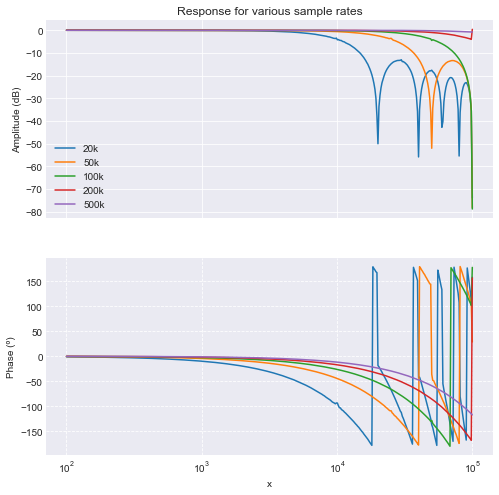

In [17]:
fig = plots.frequency_domain.amplitude_phase(amplitudes, phases, title='Response for various sample rates')
fig.axes[0].legend();

## Read/Write with Fixed Delay

The above transfer functions were made when the DAC outputs are always written immediately after being read. However, we want to do calculations in the mean time. Thus, the time delay between read and write would change depending on the amount of calculations. It might therefore be beneficial to always write the data at the beginning of the Event, i.e. with a constant time delay:

    P2_ADCF_MODE(2,1)
    ...
    P2_DAC8(module, buffer, 1)
    P2_Read_ADCF8(module, buffer, 1)

This results in an additional delay:

In [18]:
amplitude = io.import_data(base_path + '13.TXT', 'ASCII')
amplitude.columns = ['100kHz']
phases = io.import_data(base_path + '14.TXT', 'ASCII')
phases = phases.join(io.import_data(base_path + '15.TXT', 'ASCII'))
phases.columns = ['DAC:ADC', 'ADC:DAC']

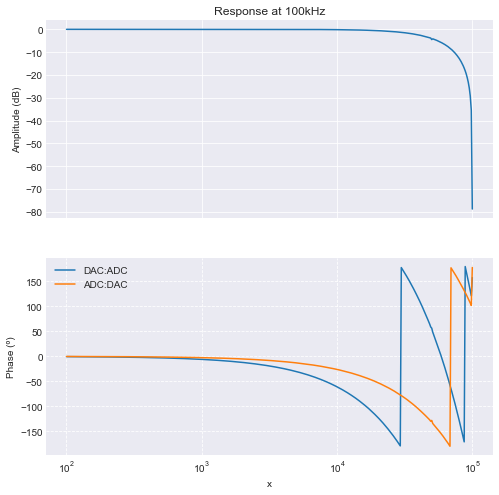

In [19]:
fig = plots.frequency_domain.amplitude_phase(amplitude, phases, title='Response at 100kHz')
fig.axes[1].legend();

Let us calculate that delay:

In [20]:
fsample = 1e5
delta_t = phases['DAC:ADC']/360/phases.index * 1e6

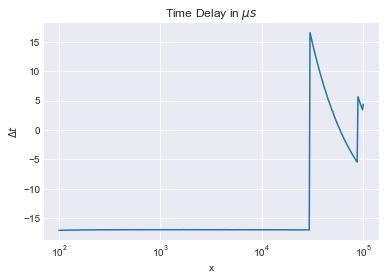

In [21]:
fig2 = delta_t.plot(logx=True, title='Time Delay in $\mu s$')
fig2.grid()
fig2.set_ylabel('$\Delta t$');

So, roughly 17us, whereas we would expect something on the order of 1/100kHz, i.e. 10us:

In [22]:
1/fsample * 1e6

10.0

At first I `P2_DAC8` to write the values, however this first needs to send the values to the DAC module and then starts the conversion, also it cannot synchronously start conversion on both output modules. Therefore I switched to `P2_Write_DAC8` at the end of the Event cycle, which just populates the DAC modules with new values but doesn't convert yet, and then at the start of the cycle I trigger the conversion using `P2_Sync_All`. However this did not lead to a measurable improvement in the time delay.

## Second Order Sections

The most straight forward approach for digital filters is the so-called second-order section (SOS). It has a transfer function that looks like this:

$$H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2}}{a_0 + a_1 z^{-1} + a_2 z^{-2}}\,.$$

Usually, it is normalised such that $a_0 = 1$. Any second-order filter (e.g. pole-zero, 2nd order lowpass, notch) can be written in this form, and e.g. `scipy.signal` has functions to calculate the necessary coefficients:

In [23]:
sig.bessel(2, 0.5/fsample)

(array([6.16841884e-11, 1.23368377e-10, 6.16841884e-11]),
 array([ 1.        , -1.99997279,  0.99997279]))

A useful form to digitally calculate such filters is the so-called Direct Form II. It's equation looks like this:

$$
\begin{aligned}
  y[n] &= b_0 w[n] + b_1 w[n-1] + b_2 w[n-2] \\
  w[n] &= x[n] - a_1 w[n-1] - a_2 w[n-2]
\end{aligned}
$$

In the LIGO filters, things are slightly rearranged:

$$y[n] = b_0\bigl(x[n]-(a_1 + b_1/b_0)w[n-1] - (a_2 + b_2/b_0)w[n-2]\bigr)$$

Thus, we need the 5 coefficients

$$
\begin{aligned}
    c_0 &= b_0,\\
    c_1 &= a_1,\\
    c_2 &= a_2,\\
    c_3 &= b_1/b_0,\\
    c_4 &= b_2/b_0,
\end{aligned}
$$

and also storage space for the two _history_ items $w[n-1]$ and $w[n-2]$.

The actual code then looks like this:

    ' overall gain
    out = sos_input * filter_coeffs[1]
    ' poles
    out = out - filter_history[1] * filter_coeffs[2]
    new_history = out - filter_history[2] * filter_coeffs[3]  
    ' zeros
    out = new_history + filter_history[1] * filter_coeffs[4]
    out = out + filter_history[2] * filter_coeffs[5]
    filter_history[2] = filter_history[1]
    filter_history[1] = new_history

... where indexing in ADwin-Basic starts with 1. And, it works! Here's an example with 4 notch filters and a low-pass filter:

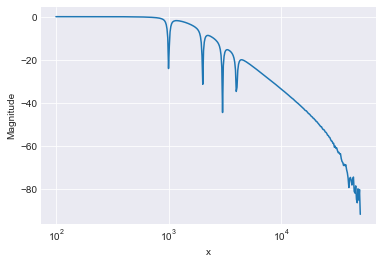

In [24]:
amplitude = io.import_data(base_path + '16.TXT', 'ASCII')
fig = amplitude.plot(logx=True,legend=False)
fig.grid()
fig.set_ylabel('Magnitude');

At 100kHz sample rate and with 8 filter modules, $8*5 = 40$ SOSs, 200 coefficients, this runs at about 46% CPU load (T12 processor module).

## Global Arrays and Parameters

### Control register

#### Par_1: Timer
Time the program is already active. Measured in seconds.

#### Par_2: Filter bank control register (FBCR)
The least significant byte is used to initiate a reload of filter coefficients from the global data array (i.e., the one that is written to from the control PC). If a bit is set, the filter coefficients of the respective bank are reloaded. Afterwards, the bit is automatically cleared.
<table>
<thead>
<tr>
<th> bit </th>
<th> 7 </th>
<th> 6 </th>
<th> 5 </th> 
<th> 4 </th> 
<th> 3 </th>
<th> 2 </th> 
<th> 1 </th>
<th> 0 </th>
</tr>
</thead>
<tr>
<th> filter bank</th>
<td> 8 </td>
<td> 7 </td>
<td> 6 </td>
<td> 5 </td> 
<td> 4 </td>
<td> 3 </td>
<td> 2 </td>
<td> 1 </td>
</tr>
</table>

#### Par_3: Ramp control register (RCR)
The least significant byte determines which channel should output a ramp. 0 is no output
and values from 1-15 correspond to the output with the respective number. The byte before that determines the step size at which the program writes values from the ramp array. For example for a value of 1, every index of the ramp array is used, while for a value of 2 every second value is written and therefore ramp frequency is doubled. 
<table>
<thead>
<tr>
<th> bit </th> 
<th> 15 </th>
<th> 14 </th>
<th> 13 </th>
<th> 12 </th>
<th> 11 </th>
<th> 10 </th>
<th> 9 </th>
<th style="border-right: 1px solid"> 8 </th>
<th> 7 </th>
<th> 6 </th>
<th> 5 </th>
<th style="border-right: 1px solid"> 4 </th>
<th> 3 </th>
<th> 2 </th> 
<th> 1 </th>
<th> 0 </th>
</tr>
</thead>
<tr>
<th> description </th>
<td colspan=8 style="border-right: 1px solid">step size</td> 
<td colspan=4 style="border-right: 1px solid">unused</td>
<td colspan=4>ramp channel</td>
</tr>
</table>

#### Par_5: Monitor selection (?)
Selection of channel for the monitor function. Writes the input to DAC channel 9, the corresponding aux input to DAC channel 10 and the output to DAC channel 11.

#### Par_4: Active selection (active_sel)
Selection of channel for active data. Writes the input, corresponding aux input and output in the `active_data` array, which is accessible from the PC.

#### Par_8: Input sensitivity

| bit    | channel |
| ------ | ------- |
| 0, 1   | 1       |
| 2, 3   | 2       |
| ...    | ...     |
| 30, 31 | 16      |


#### Par_11..18: Filter control register (fcr_1..8)

Controls which functions of the respective filter (1..8) are enabled, e.g. bit 0 controls the input switch which enabled/disables the input into the filter.
<table>
<thead>
<tr>
<th> bit </th>
<th> 9 </th>
<th> 8 </th>
<th> 7 </th>
<th> 6 </th>
<th> 5 </th>
<th> 4 </th>
<th> 3 </th>
<th> 2 </th>
<th> 1 </th>
<th> 0 </th>
</tr>
</thead>
<tr>
<td> description </td>
<td> AUX </td>
<td> SOS 5 </td>
<td> SOS 4 </td>
<td> SOS 3 </td>
<td> SOS 2 </td>
<td> SOS 1 </td>
<td> unused </td>
<td> offset sw </td>
<td> output sw </td>
<td> input sw </td>
</tr>
</table>


### Data Arrays
#### Filter coefficients (Data_1)
Contains the filter coefficients. 5 for each SOS and 5 SOS for each filter module. The first 5 entries of each Filter correspond to the first SOS the second to the second and so on. For the calculation the values are refactored as mentioned above.
The assignment of Array indexes is the following:

<html>
<body>
<table>
<thead>
<tr>
<th> index <th>
<th> 1-25 <th>
<th> 26-50 <th>
<th> 51-75 <th>
<th> 76-100 <th>
<th> 101-126 <th>
<th> 126-150 <th>
<th> 151-175 <th>
<th> 176-200 <th>
</tr>
</thead>
<td> Filter Module <td>
<td> 1 <td>
<td> 2 <td>
<td> 3 <td>
<td> 4 <td>
<td> 5 <td>
<td> 6 <td>
<td> 7 <td>
<td> 8 <td>
<tr>
</tr>
</table>
</body>
</html>


#### Offset and gain (Data_2)
Contains information for the offset and gain of the filter modules.

| Index         | 1 – 8      | 9 – 16       |
|:------------- |:---------- |:------------ |
| Filter Number | Gain 1 – 8 | Offset 1 – 8 |

### FIFO output
* adc_input_1 (Data_3)
* adc_input_2 (Data_4)
* dac_output (Data_5)

#### FIFO Tests
* Writing of one channel with 3 values to FIFO needs about $500 \mathrm{ns}$.
* Reading of all three values with the maximum rate needs about $1.5\mathrm{MB/s}$.
* Current process time (without FIFO channels) $5037 \mathrm{ns}$.
* With the current rate of $100 \mathrm{kHz}$ is it possible to write all 8 channels to FIFO.

## Calculation of digital filters with Python
The filters are designed in the contineous s-plane. To get a discrete time version usable for calculation in realtime with a set frequency, one has to transform the contineous transfer function. The time discret version of the laplace transform is the z-transform. The mapping between s and z is:
$$
z(s)=e^{sT}\,,
$$
or alternatively,
$$
s(z)= \frac{1}{T}\ln(z)\,,
$$
with $T$ being the inverse sampling rate. Since $\ln(z)$ is a continuous function and therefore not useful for the calculation with second order sections one has to expand it and stop the expansion after a certain order. One way to do this is stopping the expansion after the first order, this is the so called bilinear transform,
$$
s \rightarrow \frac{2}{T}\frac{z-1}{z+1}\,.
$$
Since the whole frequency axis gets mapped on the unit circle the transfer functions calculated and designed in the $s$ plane have to be prewarped. This is done by changing the relevant frequencies with:
$$
w'=\frac{2}{T}\tan\left(\omega\frac{T}{2}\right).
$$
The prewarping transform in the code is done after the poles and zeros were calculated and not beforehands.
$$
{\rm prewarp}(x)=\frac{x}{|x|}\frac{2}{T}\cdot \tan\left(0.5\pi \cdot \frac{|x|}{f_n} \right)
$$
$x$ is the position of the pole/zero in the frequency domain and $f_n$ the nyquist frequency.
This can lead to errors for Filter with a higher order than 1.$$ \\ $$ 
But for most cases there is no difference as one can see at the example of the second order lowpass and the second order notch filter. The location of the poles $p_{1,2}$ for both is:
$$
p_{1,2}=-\frac{f_0}{2Q}\pm \sqrt{\left(\frac{f_0}{2Q}\right)^2-f_0^2}\,.
$$
For Q Values larger than 0.5 the absolute square is:
$$
||p_{1,2}||^2=\left(\frac{f_0}{2Q}\right)^2 +f_0^2 -\left(\frac{f_0}{2Q}\right)^2 = f_0^2\,.
$$
So the result of the bilinear transform is the exact same for any Q value larger than 0.5.

## Special properties of the Adwin System

### Integer Overflow of the write DAC
Since the ADwin system works with 32 bit signed integer numbers and the DAC-module takes only unsigned 16 bit integers, an overflow is created when numbers smaller than 0 or numbers larger than 65535 are used. For values smaller than 0 the last 15 bits and the sign bit are interpreted as 16 bit integer number. For values larger than 65535 the last 16 bits are cutoff so for example. If one wants to write 65536 in the output one gets a 0 which represents -10V or for the negative value of -1 one gets an output of 3.

### Functions are macros
Care needs to be taken when specifying calculations in function arguments, as they really are only macros that get replaced inline. E.g., if one has a function

```
Function MultiplyBy2(x) as Integer
    MultiplyBy2 = x * 2
EndFunction
```

and then calls this function like `MultiplyBy2(a+1)`, this gets replaced with the actual code `a+1 * 2`, which is obviously evaluated to `a + 2` instead of `(a+1) * 2`.


## Measurements

### Average filter

| Average | Gain 100Hz  [dB] | Gain 10kHz [dB] | Phase 100Hz [°] | Phase 10kHz [°] | Aliasing (*) |
|:------- |:---------------- |:--------------- |:--------------- | --------------- | ------------ |
| 0       | 0.04             | **-0.19**       | -0.70           | -68.59          | **5.00**     |
| 8       | 0.04             | **-0.19**       | -0.88           | -86.31          | **2.32**     |
| 32      | 0.04             | **-0.85**       | -1.05           | -101.29         | **0.65**     |

(*) 1.6Hz Aliasing, Pk-Pk [V]. Input signal: 200kHz, 5Vpp